# Analysis of Peptide Trajectory

In this notebook, we analyze an all-atom MD simulation of a peptide system in explicit solvent using `MDAnalysis` python pachage. We focus on extracting key structural and dynamic properties relevant for aggregation behavior and peptide phase behavior:

- Backbone RMSD
- Radius of gyration (Rg)
- Peptide-peptide contact frequency
- Diffusion estimation (MSD)
- Cluster size distribution (simple k-means)

Trajectory: 50 ns with 500 ps timestep
System: 100 short disordered peptides in water and ion solution (water and ions are not present in the .xtc file)

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap
from MDAnalysis.analysis import distances
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### Loading the trajectory

In [2]:
u = mda.Universe('../data/initial.pdb','../data/pbc.md.xtc')

In [25]:
# natoms = u.trajectory.n_atoms
nframes = u.trajectory.n_frames
dt = u.trajectory.dt
units = u.trajectory.units
protein = u.select_atoms("protein and not resname ACE and not resname NME") #contains only protein information; here is the same as all atoms
nchains = u.select_atoms('resname ACE and name CH3').n_atoms
natoms = protein.n_atoms
natoms_perchain = int(natoms/nchains)
residues = np.unique(u.residues.resnames)

In [26]:
print("Trjectory of",nframes,"frames of", u.trajectory.totaltime, units['time'], "with a timestep of", dt, units['time'])
print("There is", natoms,"total atoms (", nchains,"chains each of",natoms_perchain,"atoms )")
print("Unique residues ", residues)

Trjectory of 101 frames of 50000.0 ps with a timestep of 500.0 ps
There is 9400 total atoms ( 100 chains each of 94 atoms )
Unique residues  ['ACE' 'GLN' 'GLY' 'NME' 'TYR']


In [27]:
chains = [protein[i*natoms_perchain:(i+1)*natoms_perchain] for i in range(nchains)]

In [28]:
allresids = protein.residues
nres = int(len(allresids)/nchains)
chainresids = [allresids[i*nres:(i+1)*nres] for i in range(nchains)]

In [90]:
nres

8

In [29]:
times = np.arange(0,u.trajectory.totaltime+dt,dt)

### RMSD of Backbone

In [30]:
Rs = []
for chain in chains:
    R = rms.RMSD(chain, select='backbone')
    R.run()
    Rs.append(R.rmsd[:,2])

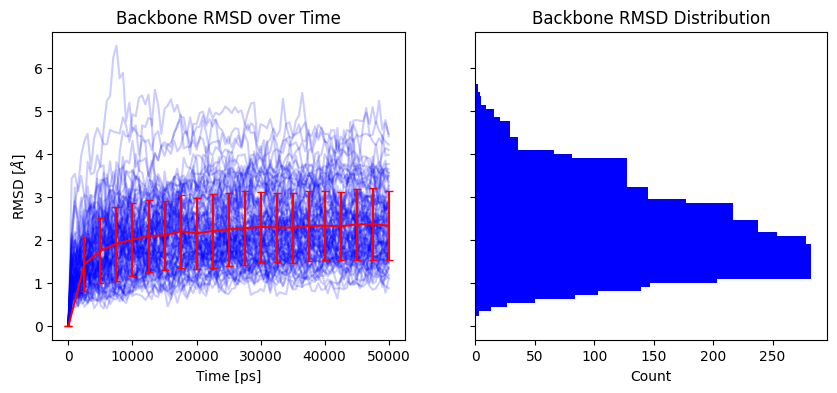

In [31]:
aveR = np.mean(Rs,axis=0)
stdR = np.std(Rs,axis=0)
fig,ax = plt.subplots(1,2,figsize=(10,4), sharey=True)
for R in Rs: 
    ax[0].plot(times, R, alpha=0.2, c='b')
ax[0].errorbar(times[::5],aveR[::5],stdR[::5],capsize=3, c='r', label='average')
ax[0].set_xlabel("Time [ps]")
ax[0].set_ylabel("RMSD [$\AA$]")
ax[0].set_title("Backbone RMSD over Time")
# ax[0].grid(True)

# flatting out list of RMSDs and only looking at the second part of the trajectory
hlen = int(nframes/2)
Rs_flat = [i for j in Rs for i in j[hlen:]]
h,b = np.histogram(Rs_flat,bins=50)
ax[1].barh(b[:-1],h,color='b')
ax[1].set_xlabel('Count')
# ax[1].grid(True)
ax[1].set_title("Backbone RMSD Distribution")
plt.show()

### Radius of Gyration

In [32]:
rgs = []
times = []

for ts in u.trajectory:
    rg_ch = []
    for chain in chains:
        rg = chain.radius_of_gyration()
        rg_ch.append(rg)
    rgs.append(rg_ch)
    times.append(u.trajectory.time)

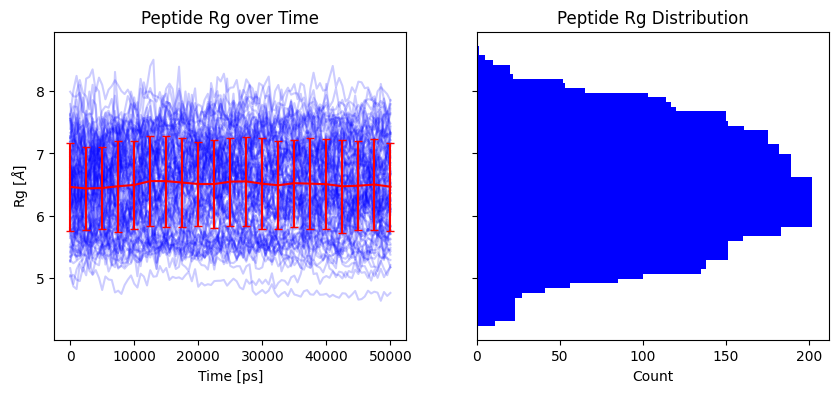

In [33]:
aveRgs = np.mean(rgs,axis=1)
stdRgs = np.std(rgs,axis=1)
fig,ax = plt.subplots(1,2,figsize=(10,4), sharey=True)

ax[0].plot(times, rgs, c='b', alpha=0.2)
ax[0].errorbar(times[::5],aveRgs[::5],stdRgs[::5],capsize=3, c='r', label='average')
ax[0].set_xlabel("Time [ps]")
ax[0].set_ylabel("Rg [$\AA$]")
ax[0].set_title("Peptide Rg over Time")
# ax[0].grid(True)

# flatting out list of RMSDs and only looking at the second part of the trajectory
hlen = int(nframes/2)
Rgs_flat = [i for j in rgs[hlen:] for i in j]
h,b = np.histogram(Rgs_flat,bins=50)
ax[1].barh(b[:-1],h,color='b')
ax[1].set_xlabel('Count')
# ax[1].grid(True)
ax[1].set_title("Peptide Rg Distribution")
plt.show()

### Inter-Peptide Contact Frequency (Matrix)

In [43]:
len(chainresids),chainresids[0][-1], chains[30].resids

(100,
 <Residue GLY, 9>,
 array([2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7,
        7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9,
        9, 9, 9, 9, 9, 9]))

In [88]:
# Assuming 5 peptides: chainID A-E
# chains = ['A', 'B', 'C', 'D', 'E']
pairs = [(i, j) for i in range(nchains) for j in range(nchains) if i != j]
contacts = zeros((nres,nres)) # {pair: 0 for pair in pairs}

for ts in u.trajectory[::10]:  # sample every 10th frame
    for i, j in pairs:
        ca1 = chains[i].select_atoms('name CA')
        ca2 = chains[j].select_atoms('name CA')
        res1,res2,dist = distances.dist(ca1,ca2,offset=0,box=u.dimensions)
        if (dist < 5.0).any():
            contacts[res1, res2] += 1


In [93]:
res1,res2,dist
for r in res1:

(array([2., 3., 4., 5., 6., 7., 8., 9.]),
 array([2., 3., 4., 5., 6., 7., 8., 9.]),
 array([28.82118742, 30.20372808, 27.96861643, 33.02409844, 30.73342143,
        30.55857316, 33.11857761, 34.40593041]))

In [89]:
# Plot heatmap
matrix = np.zeros((nres, nres))
for (i, j), v in contacts.items():
    idx1, idx2 = i, j
    matrix[idx1, idx2] = matrix[idx2, idx1] = v

sns.heatmap(matrix, annot=True, xticklabels=range(nres), yticklabels=range(nres))
plt.title("Inter-Peptide Contact Frequencies")
plt.show()

IndexError: index 8 is out of bounds for axis 1 with size 8

In [81]:
ca1 = chains[0].select_atoms('name CA')
ca2 = chains[1].select_atoms('name CA')
res1,res2,dist = distances.dist(ca1,ca2,offset=0,box=u.dimensions)

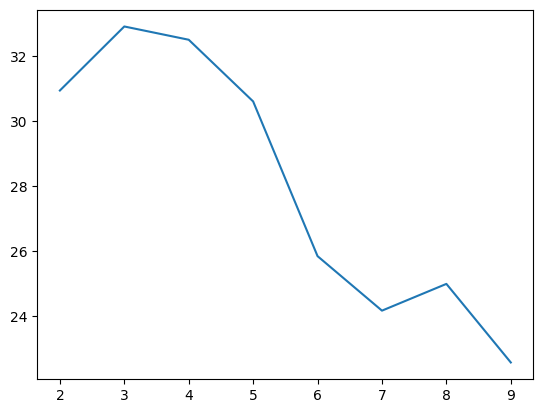

In [82]:
plt.plot(res2,dist)